In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpt
from matplotlib.pyplot import subplots, imshow, figure, plot, bar
import os
from os.path import join
import re
import json
import pickle
import sys
sys.path.append('../misc/tracecmd')
import tracecmd

## Loading experiment data

In [3]:
expname = '04-11_05-01' # <-- replace with experiment name

def load_experiment(expname):
    expbase = join('../exp', expname)
    with open(join(expbase, 'experiment.json')) as f:
        expdata = json.load(f)
    if os.path.exists(f := join(expbase, 'main.json')):
        with open(f) as f:
            expdata['main'] = json.load(f)
    expfiles = os.listdir(expbase)
    loads = {}
    for x in expfiles:
        if m := re.fullmatch(r'load\.(.+)\.pkl', x):
            with open(join(expbase, x), 'rb') as f:
                load = pickle.load(f)
                load['times'] = np.array(load['times'])
                loads[m.group(1)] = load

    trace = tracecmd.Trace(join(expbase, 'trace.dat'))
    events = []
    while (event := trace.read_next_event()) != None:
        events.append(event)
    events = sorted(events, key=lambda e: e.ts)
    return expdata, loads, events

expdata, loads, events = load_experiment(expname)
gds_events = [e for e in events if e.name == 'global_dirty_state']
bdp_events = [e for e in events if e.name == 'balance_dirty_pages']
print('{} experiment:\n - kernel: {}\n - {} tracer events, {} loads\n - duration {:.2f}s'.format( \
    expdata.get('kind', 'uml'), expdata['kernel'], len(events), len(loads), np.diff(loads['c1']['times'][[0,-1]])[0]))

live experiment:
 - kernel: 5.7.2-arch1-1
 - 5558 tracer events, 3 loads
 - duration 212.88s


## Timeline

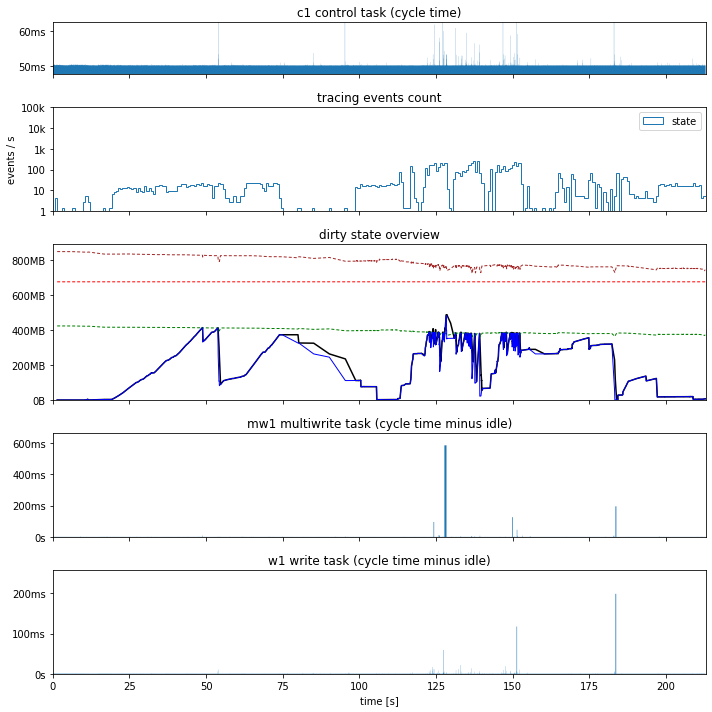

In [5]:
start, end = loads.get('l1', loads['c1'])['times'][[0,-1]]

def render_segments(ax, edges, values, *args, **kwargs):
    if len(edges) != len(values)+1:
        raise Exception('Got {} edges, {} values'.format(len(edges), len(values)))
    res = ax.fill_between(np.repeat(edges, 2)[1:-1], np.repeat(values, 2), -1, *args, **kwargs)
    ax.set_ylim(0, ax.get_ylim()[1])
    return res

def p_event_density(ax):
    ax.set_title('tracing events count')
    ax.set_ylabel('events / s')
    def plot_times(events, *args, **kwargs):
        if not len(events): return
        ts = np.array([ e.ts / 1e9 for e in events ]) - start
        bins = min(int((end - start) / .4), 300)
        weights = [bins / (end - start)]*len(ts)
        ax.hist(ts, range=ax.get_xlim(), weights=weights, bins=bins, log=True, histtype='step', *args, **kwargs)
    plot_times(gds_events, label='state')
    plot_times(bdp_events, label='balance')
    ax.set_ylim(1,100e3)
    ax.yaxis.set_ticks((1,1e1,1e2,1e3,1e4,1e5))
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep=''))
    ax.legend()

def p_dirty_state(ax):
    ax.set_title('dirty state overview')
    from_pages = lambda pages: pages * 4096
    ts = np.array([ e.ts / 1e9 for e in gds_events ]) - start
    ax.plot(ts, [ from_pages(int(e['background_thresh'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='green', label='background thresh.')
    ax.plot(ts, [ from_pages(int(e['dirty_thresh'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='brown', label='dirty thresh.')
    ax.plot(ts, [ from_pages(int(e['dirty_limit'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='red', label='dirty limit')
    ax.plot(ts, [ from_pages(int(e['nr_dirty'])+int(e['nr_writeback'])) for e in gds_events ], color='black', label='dirty + writeback', zorder=-1)
    ax.plot(ts, [ from_pages(int(e['nr_dirty'])) for e in gds_events ], color='blue', lw=1, label='dirty', )
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='B'))
    ax.set_ylim(0, ax.get_ylim()[1])
    #ax.legend()

def p_control_task(ax, ln='c1'):
    load = loads[ln]; ps = load['params']; ts = load['times'] - start
    ax.set_title('{} control task (cycle time)'.format(ln))
    render_segments(ax, ts, np.diff(ts))
    ax.set_ylim(ps['idle']*(1-.05), ps['idle']*1.25)

def p_load_task(ax, ln='l1'):
    load = loads[ln]; ps = load['params']; ts = load['times'] - start
    ax.set_title('{} {} task (cycle time)'.format(ln, load['kind']))
    ts = ts[1:]
    render_segments(ax, ts, np.diff(ts))

def p_idle_task(ax, ln='w1'):
    load = loads[ln]; ps = load['params']; ts = load['times'] - start
    ax.set_title('{} {} task (cycle time minus idle)'.format(ln, load['kind']))
    render_segments(ax, ts, np.diff(ts) - ps['idle'])


panes = [
    (0.5, p_control_task, dict()),
    (1, p_event_density, dict()),
    (1.5, p_dirty_state, dict()),
    *([(1, p_load_task, dict(ln='l1'))] if 'l1' in loads else []),
    (1, p_idle_task, dict(ln='mw1')),
    *([(1, p_load_task, dict(ln='l2'))] if 'l2' in loads else []),
    (1, p_idle_task, dict(ln='w1')),
]
fig, axs = subplots(sharex=True, figsize=(10,10), nrows=len(panes), tight_layout=True, gridspec_kw=dict( height_ratios=[ x[0] for x in panes ] ))
axs[-1].set_xlim(0, end - start)

for ax, (_, fn, kwargs) in zip(axs, panes):
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='s'))
    fn(ax, **kwargs)

for ax in axs:
    for load in loads.values():
        if load['kind'] == 'load':
            ax.plot([ load['times'][1] - start ]*2, ax.get_ylim(), lw=1, ls=(0, (4,4)), color='black')
    if 'main' in expdata:
        ax.plot([ expdata['main']['start'] - start ]*2, ax.get_ylim(), lw=1, ls=(0, (4,4)), color='black')
axs[-1].set_xlabel('time [s]')
#axs[-1].xaxis.set_major_locator(mpt.MultipleLocator(10))

## Zoomed timeline

In [81]:
start, end = loads.get('l1', loads['c1'])['times'][[0,-1]]

def render_segments(ax, edges, values, *args, **kwargs):
    if len(edges) != len(values)+1:
        raise Exception('Got {} edges, {} values'.format(len(edges), len(values)))
    res = ax.fill_between(np.repeat(edges, 2)[1:-1], np.repeat(values, 2), -1, *args, **kwargs)
    ax.set_ylim(0, ax.get_ylim()[1])
    return res

def p_gds_density(ax):
    ax.set_title('global_dirty_state events count')
    ax.set_ylabel('events')
    def plot_times(events, *args, **kwargs):
        if not len(events): return
        ts = np.array([ e.ts / 1e9 for e in events ]) - start
        bins = min(int((end - start) / .4), 300)
        weights = [bins / (end - start)]*len(ts)
        ax.hist(ts, range=ax.get_xlim(), bins=bins, log=False, *args, **kwargs)
    plot_times(gds_events, label='state')
    #plot_times(bdp_events, label='balance')
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep=''))

def p_event_density(ax):
    ax.set_title('tracing events count')
    ax.set_ylabel('events / s')
    def plot_times(events, *args, **kwargs):
        if not len(events): return
        ts = np.array([ e.ts / 1e9 for e in events ]) - start
        bins = min(int((end - start) / .4), 300)
        weights = [bins / (end - start)]*len(ts)
        ax.hist(ts, range=ax.get_xlim(), weights=weights, bins=bins, log=True, histtype='step', *args, **kwargs)
    for name in ['wbc_writepage', 'writeback_dirty_inode_enqueue', 'balance_dirty_pages']:
        evs = [e for e in events if e.name == name]
        if not len(evs): continue
        plot_times(evs, label=name)
    ax.set_ylim(1,100e3)
    ax.yaxis.set_ticks((1,1e1,1e2,1e3,1e4,1e5))
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep=''))
    ax.legend()

def p_dirty_state(ax):
    ax.set_title('dirty state overview')
    from_pages = lambda pages: pages * 4096
    ts = np.array([ e.ts / 1e9 for e in gds_events ]) - start
    ax.plot(ts, [ from_pages(int(e['background_thresh'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='green', label='background thresh.')
    #ax.plot(ts, [ from_pages(int(e['dirty_thresh'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='brown', label='dirty thresh.')
    #ax.plot(ts, [ from_pages(int(e['dirty_limit'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='red', label='dirty limit')
    ax.plot(ts, [ from_pages(int(e['nr_dirty'])+int(e['nr_writeback'])) for e in gds_events ], color='black', zorder=-1, label='dirty + writeback', marker='x', markersize=5)
    ax.plot(ts, [ from_pages(int(e['nr_dirty'])) for e in gds_events ], color='blue', lw=1, label='dirty', marker='x', markersize=5)
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='B'))
    #ax.set_ylim(0, ax.get_ylim()[1])
    ax.legend(loc='lower left')

def p_control_task(ax, ln='c1'):
    load = loads[ln]; ps = load['params']; ts = load['times'] - start
    ax.set_title('{} control task (cycle time)'.format(ln))
    render_segments(ax, ts, np.diff(ts))
    ax.set_ylim(ps['idle']*(1-.05), ps['idle']*1.25)

def p_load_task(ax, ln='l1'):
    load = loads[ln]; ps = load['params']; ts = load['times'] - start
    ax.set_title('{} {} task (cycle time)'.format(ln, load['kind']))
    ts = ts[1:]
    render_segments(ax, ts, np.diff(ts))

def p_idle_task(ax, ln='w1'):
    load = loads[ln]; ps = load['params']; ts = load['times'] - start
    ax.set_title('{} {} task (cycle time minus idle)'.format(ln, load['kind']))
    render_segments(ax, ts, np.diff(ts) - ps['idle'])


panes = [
    (.5, p_control_task, dict()),
    (.5, p_gds_density, dict()),
    #(.5, p_event_density, dict()),
    (1.5, p_dirty_state, dict()),
    #(.5, p_idle_task, dict(ln='mw1')),
]
fig, axs = subplots(sharex=True, figsize=(18,6), nrows=len(panes), gridspec_kw=dict( height_ratios=[ x[0] for x in panes ] ))
axs[-1].set_xlim(0, end - start)

for ax in axs:
    #ax.grid(axis='x')
    #ax.set_ylabel('duration [s]')
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='s'))

for ax, (_, fn, kwargs) in zip(axs, panes):
    fn(ax, **kwargs)

t1, t2 = np.array(axs[-1].get_xlim()) + start
for ti in loads['mw1']['times']:
    if not t1 <= ti <= t2: continue
    for ax in axs:
        ax.plot([ ti - start ]*2, _tmp := ax.get_ylim(), lw=1, ls=(0, (4,4)), color='grey', zorder=-5)
        ax.set_ylim(_tmp)
axs[-1].set_xlabel('time [s]')
axs[-1].xaxis.set_major_locator(mpt.MultipleLocator(1))
fig.tight_layout()

2

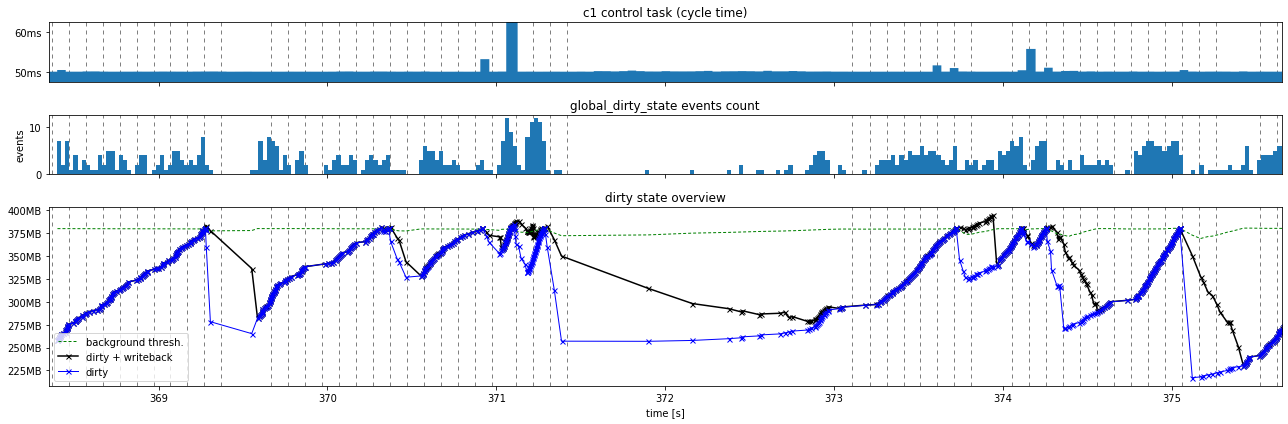

In [79]:
2

## Event fiddling

In [127]:
#evs = [e for e in events if e.name == 'sb_clear_inode_writeback' ]
evs = [e for e in events if e.pid == loads['mw1']['pid'] ]

exit_syscall = events[1023285]
evs = events[1023285-5 : 1023285]

In [117]:
dirty_state_flags = ['DIRTY_SYNC', 'DIRTY_DATASYNC', 'DIRTY_PAGES', 'NEW', 'WILL_FREE', 'FREEING', 'CLEAR', 'SYNC', 'REFERENCED', 'DIO_WAKEUP', 'LINKABLE', 'DIRTY_TIME', 'DIRTY_TIME_EXPIRED', 'WB_SWITCH', 'OVL_INUSE', 'CREATING', 'DONTCACHE']
def parse_flags(n, flags):
    assert not (n >> len(flags))
    return set(f for i, f in enumerate(flags) if (n >> i) & 1)

num_field = lambda f: int.from_bytes(f.data, 'little')
def num_fields(*fs):
    return { x: num_field for x in fs }
writeback_fields = {
    **num_fields('dev', 'ino', 'mode', 'dirtied_when'),
    'state': lambda f: parse_flags(num_field(f), dirty_state_flags),
}
event_defs = {
    'writeback_dirty_inode_enqueue': writeback_fields,
    'sb_clear_inode_writeback': writeback_fields,
}
def parse_event(ev):
    evdef = event_defs[ev.name]
    missing = set(ev.keys()) - set(evdef)
    fields = { x: evdef[x](ev[x]) for x in ev.keys() }
    base = { '_t': ev.ts, '_name': ev.name, '_pid': ev.pid }
    return {**base, **fields}

parse_event(evs[0])

{'_t': 811900901515767,
 '_name': 'sb_clear_inode_writeback',
 '_pid': 762480,
 'dev': 266338306,
 'ino': 8808635,
 'state': set(),
 'mode': 33188,
 'dirtied_when': 4538446589}

## Pause comparison graphs

In [18]:
exps = [
    ('05-13_03-14',  'no measures taken', 'brown'),
    ('05-13_03-36',  'BFQ only', 'blue'),
    ('05-13_02-50',  'BFQ + idle + memcg', 'green'),
]
exps = [ (load_experiment(n), *l) for n, *l in exps ]

#fig, (ax1, ax2) = subplots(figsize=(7, 9), nrows=2, gridspec_kw=dict( height_ratios=[ 4, 1 ] ))
fig1, ax1 = subplots(figsize=(6,4.5), tight_layout=True)
fig2, (ax2, ax3) = subplots(figsize=(6,3), tight_layout=True, nrows=2)

pts = []
get_pts = lambda k: [ pt[k] for pt in pts ]

for (expdata, loads, events), label, color in exps:
    start, end = loads.get('l1', loads['c1'])['times'][[0,-1]]
    load = loads['mw1']
    ts = load['times'] - start
    ts = ts[ts < 410]
    dts = np.diff(ts)
    sts = np.sort(dts)[::-1]
    cts = np.cumsum(sts) - sts
    mask = cts < 200
    
    from_pages = lambda pages: pages * 4096
    gds_events = [ e for e in events if e.name == 'global_dirty_state' and e.ts / 1e9 < start + 410 ]
    ets = np.array([ e.ts / 1e9 for e in gds_events ]) - start
    dirty = np.array([ from_pages(int(e['nr_dirty'])) for e in gds_events ])
    wb = np.array([ from_pages(int(e['nr_writeback'])) for e in gds_events ])
    weights = np.diff(ets)
    weights /= np.sum(weights)
    
    ax1.plot(cts[mask], sts[mask], label=label, marker='o', color=color)
    pt = { 'label': label, 'color': color }
    pt['wait_time'] = np.sum((dts / (ts[-1] - ts[0])) * (dts / 2))
    pt['block_prob'] = np.sum(np.maximum(dts - load['params']['idle'] * 2, 0)) / (ts[-1] - ts[0])
    pt['avg_dirty'] = np.sum(dirty[:-1] * weights)
    pt['avg_writeback'] = np.sum(wb[:-1] * weights)
    pts.append(pt)

ax1.set_title('longest pauses')
ax1.legend()
ax1.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='s'))
ax1.xaxis.set_ticks([]) #ax1.xaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='s'))
ax1.set_ylabel('pause time')

ax2.set_title('wait time')
ax2.barh(np.arange(len(pts))[::-1], get_pts('wait_time'), tick_label=get_pts('label'), color=get_pts('color'))
ax2.xaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='s'))

ax3.set_title('time spent in pauses')
ax3.barh(np.arange(len(pts))[::-1], get_pts('block_prob'), tick_label=get_pts('label'), color=get_pts('color'))
ax3.xaxis.set_major_formatter(mpt.PercentFormatter(1))

2

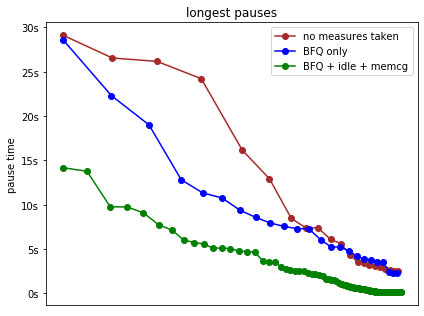

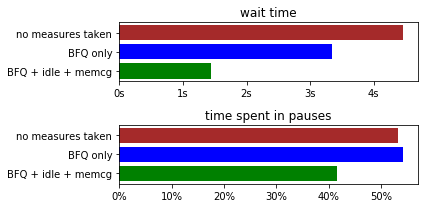

In [19]:
2